# Tensorflowを使ったJacobianの計算と平衡点の安定性解析 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import time 

import tensorflow as tf

Lorenz方程式

In [3]:

class Lorenz(object):
    """ defines Lorenz equation.
        dX/dt=f(X),
    where X = (x,y,z) is a three dimensional vector.
     arg:
        sigma,beta,rho : basic parameters of Lorenz equation
        x : A tensor of three dimensional state vector.
     returns:
      dX_dt : tensor of f(X)
    """
    def __init__(self, sigma=10., beta=8 / 3., rho=28., **kwargs):
        super().__init__(**kwargs)

        self.sigma = sigma
        self.beta = beta
        self.rho = rho

    def __call__(self, t, x):
        """ x here is [x, y, z] """
        # x = tf.cast(x, tf.float64)

        dx_dt = self.sigma * (x[1] - x[0])
        dy_dt = x[0] * (self.rho - x[2]) - x[1]
        dz_dt = x[0] * x[1] - self.beta * x[2]

        dX_dt = tf.stack([dx_dt, dy_dt, dz_dt])
        return dX_dt

# jacobian

In [4]:
def jacobian(t, f, x):
    """ return jacobian matrix of a given function f at x"""
    n = x.shape[-1].value
    fx = f(t, x)
    if x.shape[-1].value != fx.shape[-1].value:
        print('For calculating Jacobian matrix',
              'dimensions of f(x) and x must be the same')
        return

    return tf.concat([tf.gradients(fx[i], x) for i in range(0, n)], 0)


# ヤコビアンを計算するグラフの作成

In [5]:
x = tf.placeholder(dtype=tf.float64, shape=(3), name='x')
# lorenz equation
f_lorenz = Lorenz()
# operator for getting r.h.s. of ode
fx = f_lorenz(None, x) 

Df = jacobian(None,f_lorenz,x)

In [6]:

x0 = np.array([1, 2, 3], dtype=np.float64)   # initial value


In [7]:
sess =  tf.Session()
sess.run(tf.initializers.global_variables())

sess.run(Df, feed_dict={x:x0}) # Jacobian at (1,2,3)


array([[-10.        ,  10.        ,   0.        ],
       [ 25.        ,  -1.        ,  -1.        ],
       [  2.        ,   1.        ,  -2.66666667]])

# 平衡点のヤコビアン固有値計算

In [8]:
df0 = sess.run(Df, feed_dict={x:[0,0,0]}) #jacobian at origin

evals,evec = np.linalg.eig(df0) #evals: eigenvalues, evec: eigenvectors


In [9]:
print(evals)


[-22.82772345  11.82772345  -2.66666667]


In [10]:
re_evals = np.sort(evals.real)
print(re_evals)


[-22.82772345  -2.66666667  11.82772345]


In [11]:
sess.close()
tf.reset_default_graph()

# 分岐解析

分岐パラメータrhoをplaceholder型で作成してf_lorenzを作成

In [12]:
x = tf.placeholder(dtype=tf.float64, shape=(3), name='x')

#bifurcation parameter
rho = tf.placeholder(dtype=tf.float64,
                       shape=(), name='rho')

f_lorenz = Lorenz(rho=rho)
fx = f_lorenz(None, x) 
Df = jacobian(None,f_lorenz,x)

rhoを0から2まで変化させて固有値の実部の変化をプロット

In [13]:
sess=tf.Session()
sess.run(tf.initializers.global_variables())

rmin=0
rstep=0.02
rmax=2
li_rs=[]
li_eigvals=[]

for r in np.arange(rmin,rmax+rstep,rstep):
    df = sess.run(Df, feed_dict={x:(0,0,0), rho:r})
    eigvals,eigvecs = np.linalg.eig(df)
    print("rho: {:.3g} lambda: {:.4g}".format(r,eigvals.real.max()))
    li_rs.append(r)
    li_eigvals.append(eigvals)

rho: 0 lambda: -1
rho: 0.02 lambda: -0.9778
rho: 0.04 lambda: -0.9558
rho: 0.06 lambda: -0.9338
rho: 0.08 lambda: -0.912
rho: 0.1 lambda: -0.8902
rho: 0.12 lambda: -0.8686
rho: 0.14 lambda: -0.847
rho: 0.16 lambda: -0.8256
rho: 0.18 lambda: -0.8043
rho: 0.2 lambda: -0.783
rho: 0.22 lambda: -0.7619
rho: 0.24 lambda: -0.7408
rho: 0.26 lambda: -0.7198
rho: 0.28 lambda: -0.699
rho: 0.3 lambda: -0.6782
rho: 0.32 lambda: -0.6575
rho: 0.34 lambda: -0.6369
rho: 0.36 lambda: -0.6164
rho: 0.38 lambda: -0.5959
rho: 0.4 lambda: -0.5756
rho: 0.42 lambda: -0.5553
rho: 0.44 lambda: -0.5351
rho: 0.46 lambda: -0.515
rho: 0.48 lambda: -0.495
rho: 0.5 lambda: -0.4751
rho: 0.52 lambda: -0.4552
rho: 0.54 lambda: -0.4354
rho: 0.56 lambda: -0.4157
rho: 0.58 lambda: -0.3961
rho: 0.6 lambda: -0.3765
rho: 0.62 lambda: -0.357
rho: 0.64 lambda: -0.3376
rho: 0.66 lambda: -0.3183
rho: 0.68 lambda: -0.299
rho: 0.7 lambda: -0.2798
rho: 0.72 lambda: -0.2607
rho: 0.74 lambda: -0.2417
rho: 0.76 lambda: -0.2227
rho: 0.78

Text(0, 0.5, 'Re[$\\lambda_i$]')

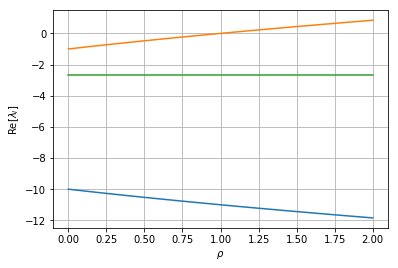

In [14]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(li_rs,li_eigvals)
ax.grid()
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'Re[$\lambda_i$]')